# Date Preprocessing for EWMA Matlab

In [1]:
import pandas as pd
import numpy as np

In [2]:
# data from 2017.1.1 to 2021.3.28
btc = pd.read_csv('data/BTC-USD.csv')
eth = pd.read_csv('data/ETH-USD.csv')
xrp = pd.read_csv('data/XRP-USD.csv')

In [3]:
# only using adj close data
btc_price = btc['Adj Close']
eth_price = eth['Adj Close']
xrp_price = xrp['Adj Close']

In [4]:
date_array = btc['Date'].to_numpy()

In [5]:
# convert price to returns and adjust length
# e.g. 1.1 $100, 1.2 : $120, return: 1.1 with ln(120) - ln(100)
return_btc = np.diff(np.log(btc_price), n=1, axis=0)
return_eth = np.diff(np.log(eth_price), n=1, axis=0)
return_xrp = np.diff(np.log(xrp_price), n=1, axis=0)

In [6]:
return_dataset = pd.DataFrame({'Date': date_array[0:-1], 'btc': return_btc, 'eth': return_eth, 'xrp': return_xrp})

In [7]:
return_dataset['btc'].isnull().values.any()

True

In [8]:
return_dataset[return_dataset['btc'].isnull()]

,Date,btc,eth,xrp
1200,2020-04-16,NaN,NaN,NaN
1201,2020-04-17,NaN,NaN,NaN
1375,2020-10-08,NaN,NaN,NaN
1376,2020-10-09,NaN,NaN,NaN
1378,2020-10-11,NaN,NaN,NaN
1379,2020-10-12,NaN,NaN,NaN
1380,2020-10-13,NaN,NaN,NaN


In [9]:
# dropna
return_dataset = return_dataset.dropna()

In [10]:
return_dataset['btc'].isnull().values.sum() + return_dataset['eth'].isnull().values.sum() + return_dataset['xrp'].isnull().values.sum() == 0

True

In [11]:
len(return_dataset) 

1540

In [17]:
return_dataset.to_csv('returns.csv', index=False)  

# Garch 1,1 Model

In [18]:
import numpy as np
import scipy
import pandas as pd
class garchOneOne(object):
       
    def __init__(self, logReturns):
        # todo: maybe need to remove this *100 
        self.logReturns = logReturns * 100
        self.sigma_2 = self.garch_filter(self.garch_optimization())
        self.coefficients = self.garch_optimization()
        
    def garch_filter(self, parameters):
        "Returns the variance expression of a GARCH(1,1) process."
        
        # Slicing the parameters list
        omega = parameters[0]
        alpha = parameters[1]
        beta = parameters[2]
        
        # Length of logReturns
        length = len(self.logReturns)
        
        # Initializing an empty array
        sigma_2 = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_2[i] = omega / (1 - alpha - beta)
            else:
                sigma_2[i] = omega + alpha * self.logReturns[i-1]**2 + beta * sigma_2[i-1]
        
        return sigma_2 
        
    def garch_loglikehihood(self, parameters):
        "Defines the log likelihood sum to be optimized given the parameters."
        length = len(self.logReturns)
        
        sigma_2 = self.garch_filter(parameters)
        
        loglikelihood = - np.sum(-np.log(sigma_2) - self.logReturns**2 / sigma_2)
        return loglikelihood
    
    def garch_optimization(self):
        "Optimizes the log likelihood function and returns estimated coefficients"
        # Parameters initialization
        parameters = [.1, .05, .92]
        
        # Parameters optimization, scipy does not have a maximize function, so we minimize the opposite of the equation described earlier
        opt = scipy.optimize.minimize(self.garch_loglikehihood, parameters,
                                     bounds = ((.001,1),(.001,1),(.001,1)))
        
        variance = .01**2 * opt.x[0] / (1 - opt.x[1] - opt.x[2])   # Times .01**2 because it concerns squared returns
        
        return np.append(opt.x, variance)

In [13]:
from arch import arch_model
import matplotlib.pyplot as plt

In [19]:
def run_garch(data,cryptoType, conf_interval):
    print("="*40)
    print("="*40)
    print ("Running Garch 1,1 model for %s" %cryptoType)
    model = garchOneOne(data)
    arch_m = arch_model(data * 100, mean = 'Zero', vol = 'GARCH')
#     arch_m = arch_model(data * 100, mean = 'Zero', vol = 'GARCH')
    arch_m = arch_m.fit()
    conf_int = pd.DataFrame(arch_m.conf_int(alpha = conf_interval))
    conf_int['garchOneOne'] = model.coefficients[:-1]
    conf_int['Test'] = np.where(conf_int['garchOneOne'] < conf_int['upper'], np.where(conf_int['garchOneOne'] > conf_int['lower'], "Ok", "Not ok"), "Not ok") 
    print("conf_int for %s" %cryptoType)
    print(conf_int)
    
    %matplotlib inline
    df = pd.DataFrame(np.sqrt(model.sigma_2))
    print(df.head())
    # Plotting the data
    plt.plot(df, label = ' GARCH(1,1)', linewidth = .75)
    plt.legend()
    plt.title('GARCH(1,1) processes of %s' %cryptoType, fontweight = 'bold')
    return model.sigma_2

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4025607.1810204433
Iteration:      2,   Func. Count:     11,   Neg. LLF: 4379.057868283349
Iteration:      3,   Func. Count:     17,   Neg. LLF: 4368.4408144556355
Iteration:      4,   Func. Count:     22,   Neg. LLF: 4335.35489445054
Iteration:      5,   Func. Count:     27,   Neg. LLF: 4590.338268655036
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4327.356646059461
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4327.3171059113065
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4327.314724933898
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4327.314672592707
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4327.314669105521
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4327.314669105828
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4327.314669105521
            Iterations: 11
            Function evaluations: 51
  

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log


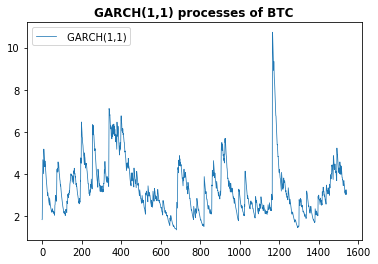

In [25]:
btc_sigma_2 = run_garch(return_dataset.btc.to_numpy(), "BTC", 0.01)

Running Garch 1,1 model for ETH
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1596589.9049798134
Iteration:      2,   Func. Count:     11,   Neg. LLF: 4850.17189170428
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4777.048963087043
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4757.1913028168565
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4757.190586275028
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4757.190584217029
Iteration:      7,   Func. Count:     35,   Neg. LLF: 4757.190584216632
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4757.190584217029
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
conf_int for ETH
             lower     upper  garchOneOne Test
omega    -0.063150  6.414499         0.10   Ok
alpha[1]  0.036752  0.254942         0.05   Ok
beta[1]   0.603288  0.924134         0.92   Ok
          0
0  1.825742
1  3.778285
2  4.884670
3  

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log


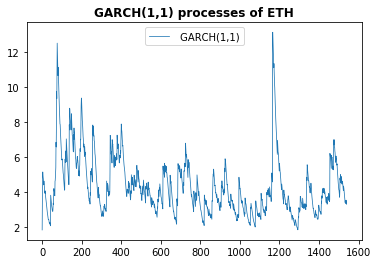

In [21]:
eth_sigma_2 = run_garch(return_dataset.eth.to_numpy(), "ETH", 0.01)

Running Garch 1,1 model for XRP
Iteration:      1,   Func. Count:      5,   Neg. LLF: 9370.45648500208
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5327.712698934334
Iteration:      3,   Func. Count:     17,   Neg. LLF: 4853.875420461771
Iteration:      4,   Func. Count:     21,   Neg. LLF: 4853.829806588084
Iteration:      5,   Func. Count:     25,   Neg. LLF: 4853.819936618181
Iteration:      6,   Func. Count:     29,   Neg. LLF: 4853.819734200685
Iteration:      7,   Func. Count:     32,   Neg. LLF: 4853.819733248238
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4853.819734200685
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
conf_int for XRP
             lower     upper  garchOneOne    Test
omega    -0.385391  7.930898         0.10      Ok
alpha[1]  0.053400  0.724826         0.05  Not ok
beta[1]   0.324932  0.896842         0.92  Not ok
          0
0  1.825742
1  1.799014
2  1.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log


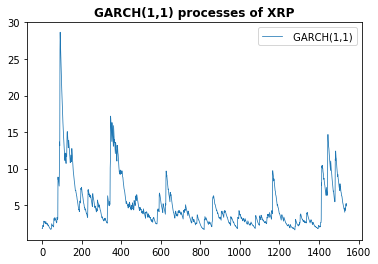

In [22]:
xrp_sigma_2 = run_garch(return_dataset.xrp.to_numpy(), "XRP", 0.01)

In [26]:
gamma_vol_99 = pd.DataFrame({'btc': return_dataset.btc, 'vol_99_btc': np.sqrt(btc_sigma_2),
              'eth': return_dataset.eth, 'vol_99_eth': np.sqrt(eth_sigma_2),
              'xrp': return_dataset.xrp, 'vol_99_xrp': np.sqrt(xrp_sigma_2)})

In [27]:
gamma_vol_99.head()

,btc,vol_99_btc,eth,vol_99_eth,xrp,vol_99_xrp
0,0.021389,1.825742,0.149056,1.825742,0.011814,1.825742
1,0.100960,1.842666,0.145785,3.778285,0.028406,1.799014
2,-0.130575,2.884490,-0.092803,4.884670,-0.057803,1.865738
3,-0.116209,4.034799,0.000029,5.133950,0.018217,2.230047
4,0.007051,4.672208,-0.038521,4.934455,0.008044,2.200271


In [78]:
gamma_vol_99.to_csv('gammas.csv', index=False)  